# Data Cleaning and Preparation
Before proceeding with analysis, we need to ensure the data is clean, especially the TotalCharges column, which needs to be converted from a string to a numeric format. Here's the complete code for preparing and analyzing the data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis, pearsonr
from scipy.stats import norm, gaussian_kde, binom_test
from statsmodels.api import OLS, add_constant

# Load the dataset
data = pd.read_csv('/Users/jwsue/Desktop/DSC630 Predictive Analytics/Telco-Customer-Churn.csv')

# Display first few rows
data.head()

# Convert 'TotalCharges' to a numeric column, coercing errors
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Fill NaN values in 'TotalCharges' with the mean of the column
data['TotalCharges'].fillna(data['TotalCharges'].mean(), inplace=True)

# Check for missing values
print(f'Missing values in each column:\n{data.isnull().sum()}')

# Display dataset information
data.info()


Missing values in each column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneS

# Descriptive Statistics and Histograms
We'll calculate the descriptive statistics and plot histograms for each of the selected variables. This will help identify the data's shape, spread, and any outliers.

tenure:
Mean: 32.37
Mode: 1.00
Standard Deviation: 24.56
Skewness: 0.24
Kurtosis: -1.39

MonthlyCharges:
Mean: 64.76
Mode: 20.05
Standard Deviation: 30.09
Skewness: -0.22
Kurtosis: -1.26

TotalCharges:
Mean: 2283.30
Mode: 20.20
Standard Deviation: 2265.00
Skewness: 0.96
Kurtosis: -0.23



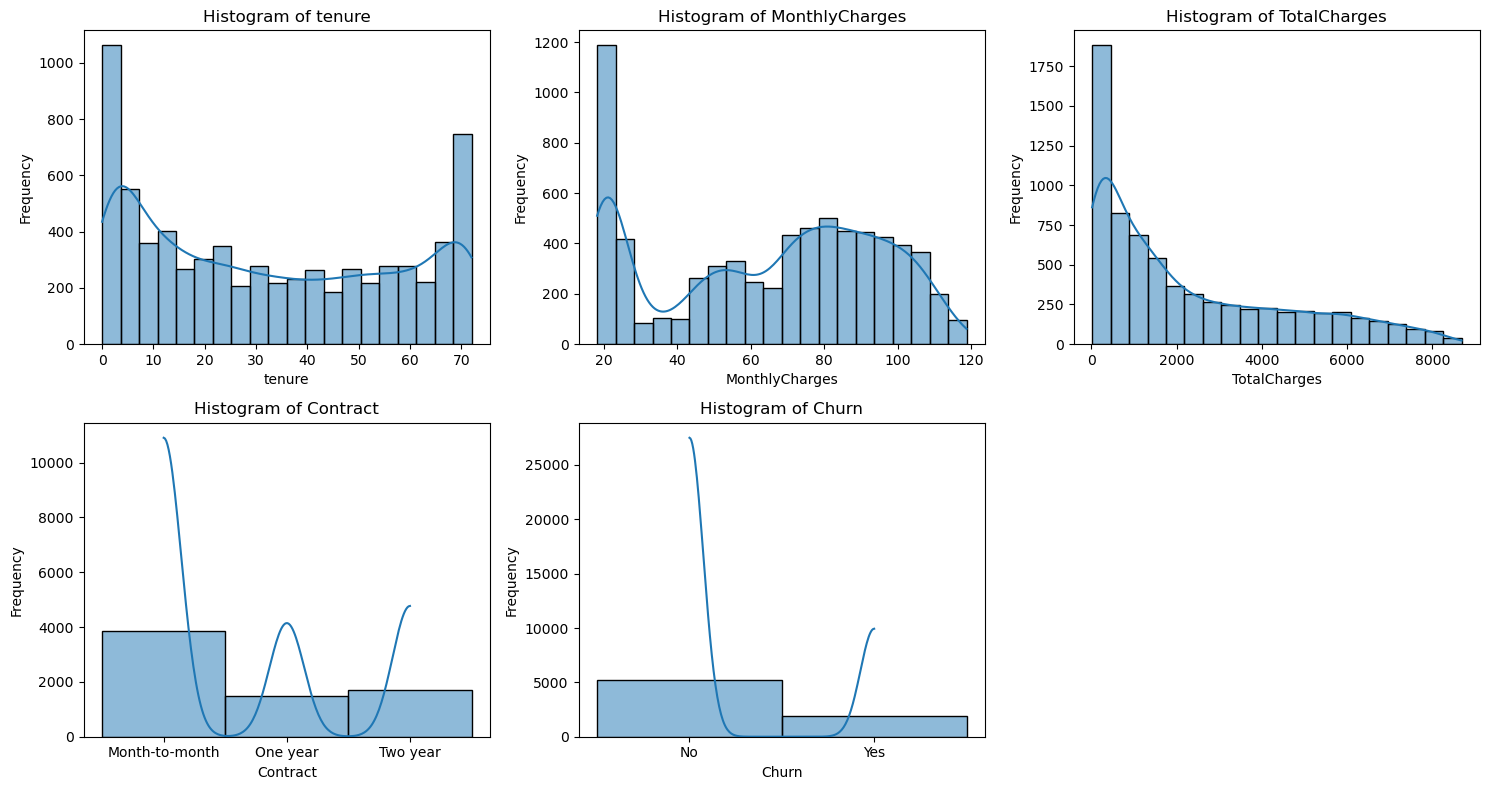

In [2]:
# Calculate descriptive statistics
descriptive_stats = {}
for var in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    descriptive_stats[var] = {
        'Mean': data[var].mean(),
        'Mode': data[var].mode()[0],
        'Standard Deviation': data[var].std(),
        'Skewness': data[var].skew(),
        'Kurtosis': data[var].kurtosis()
    }

# Print descriptive statistics
for var, stats in descriptive_stats.items():
    print(f'{var}:')
    for stat_name, stat_value in stats.items():
        print(f'{stat_name}: {stat_value:.2f}')
    print()

# Function to plot histograms
def plot_histograms(df, columns):
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(columns, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[col], bins=20, kde=True)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Plot histograms for selected variables
plot_histograms(data, ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract', 'Churn'])


# Handling Outliers
Outliers can significantly impact statistical analysis. We'll detect and handle outliers using the Interquartile Range (IQR) method.

In [3]:
# Function to detect outliers using IQR
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Detect outliers for tenure, MonthlyCharges, and TotalCharges
tenure_outliers = detect_outliers(data, 'tenure')
monthly_outliers = detect_outliers(data, 'MonthlyCharges')
total_outliers = detect_outliers(data, 'TotalCharges')

print(f'Outliers in tenure: {len(tenure_outliers)}')
print(f'Outliers in MonthlyCharges: {len(monthly_outliers)}')
print(f'Outliers in TotalCharges: {len(total_outliers)}')


Outliers in tenure: 0
Outliers in MonthlyCharges: 0
Outliers in TotalCharges: 0


# Probability Mass Function (PMF)
We'll use the PMF to compare the distribution of tenure for two scenarios: Churned and Not Churned customers. This will help us explore how tenure influences churn.

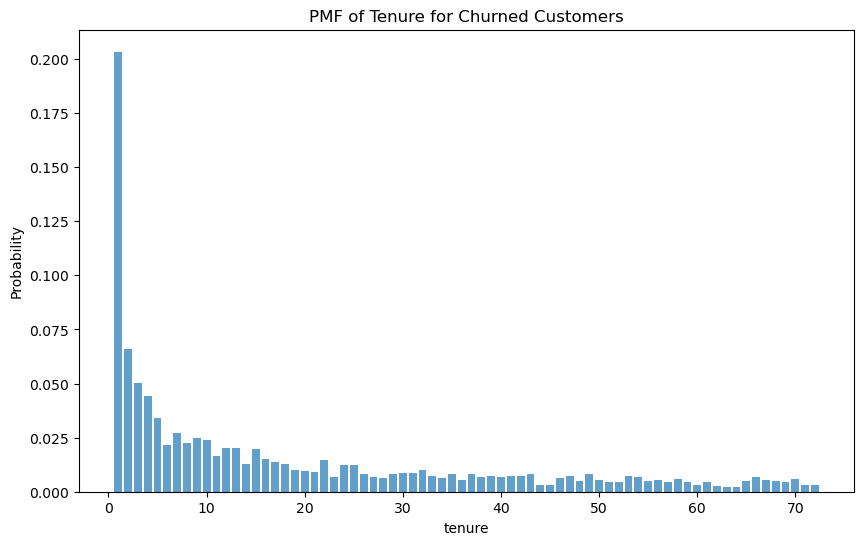

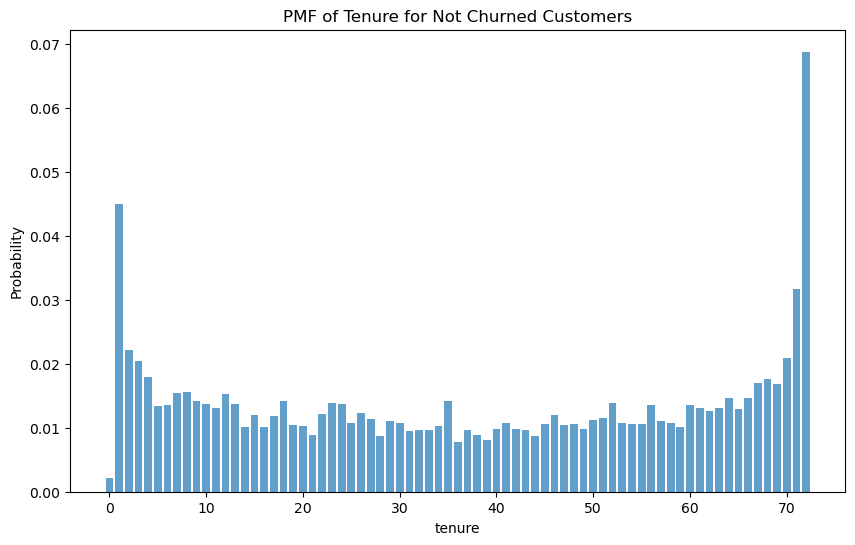

In [4]:
# PMF Function
def plot_pmf(data, column, condition, title):
    counts = data[data['Churn'] == condition][column].value_counts(normalize=True).sort_index()
    plt.figure(figsize=(10, 6))
    plt.bar(counts.index, counts.values, alpha=0.7)
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Probability')
    plt.show()

# PMF for Tenure: Churned vs. Not Churned
plot_pmf(data, 'tenure', 'Yes', 'PMF of Tenure for Churned Customers')
plot_pmf(data, 'tenure', 'No', 'PMF of Tenure for Not Churned Customers')


# Cumulative Distribution Function (CDF)

We'll analyze the CDF of the MonthlyCharges variable to understand how charges impact customer churn and provide insights into customer spending behavior.

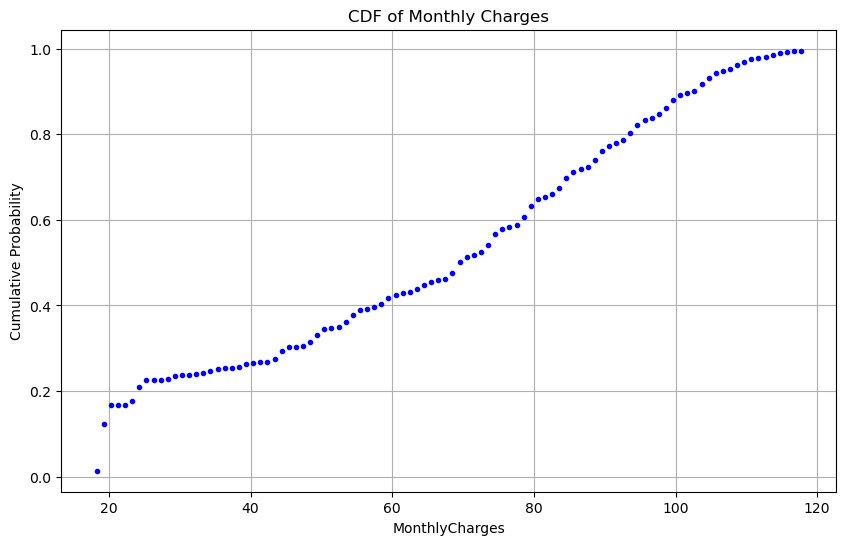

In [6]:
# CDF Plot Function
def plot_cdf(data, column, title):
    values, base = np.histogram(data[column], bins=100, density=True)
    cumulative = np.cumsum(values)
    plt.figure(figsize=(10, 6))
    plt.plot(base[:-1], cumulative, color='blue', marker='.', linestyle='none')
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Cumulative Probability')
    plt.grid(True)
    plt.show()

# CDF for MonthlyCharges
plot_cdf(data, 'MonthlyCharges', 'CDF of Monthly Charges')


# CDF Analysis
The CDF of MonthlyCharges reveals that:

A significant proportion of customers have lower monthly charges, indicating a potential churn risk.
Customers with higher charges are less frequent, suggesting premium service engagement and potentially higher retention.

# Analytical Distribution

We'll fit a normal distribution to the TotalCharges variable and analyze its suitability. This will provide insights into customer billing patterns and help understand churn dynamics.

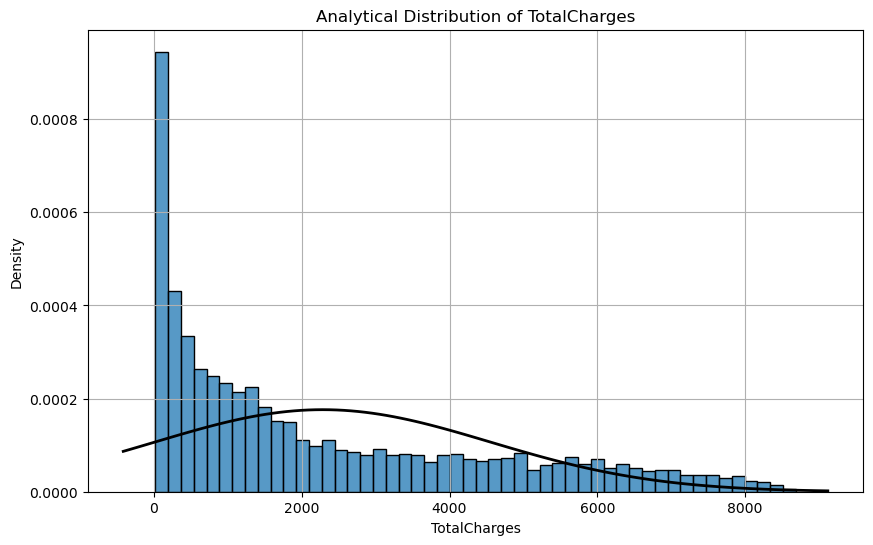

In [7]:
# Fit a normal distribution to TotalCharges
mean_total = data['TotalCharges'].mean()
std_total = data['TotalCharges'].std()

# Plot analytical distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['TotalCharges'], bins=50, kde=False, stat='density')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_total, std_total)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Analytical Distribution of TotalCharges')
plt.xlabel('TotalCharges')
plt.ylabel('Density')
plt.grid(True)
plt.show()


# Scatter Plots and Correlation Analysis
Let's create scatter plots to analyze the relationship between:

Tenure and MonthlyCharges
TotalCharges and MonthlyCharges
We'll explore correlation coefficients, covariance, and any potential causation.

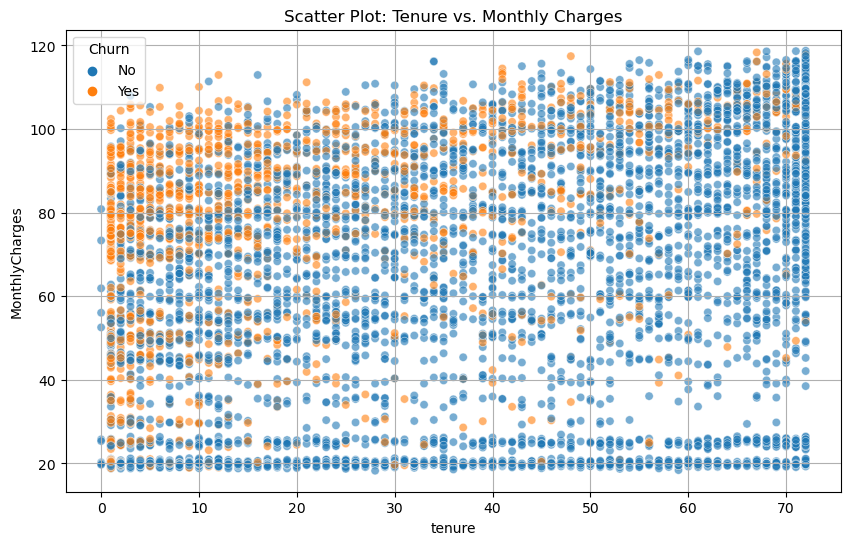

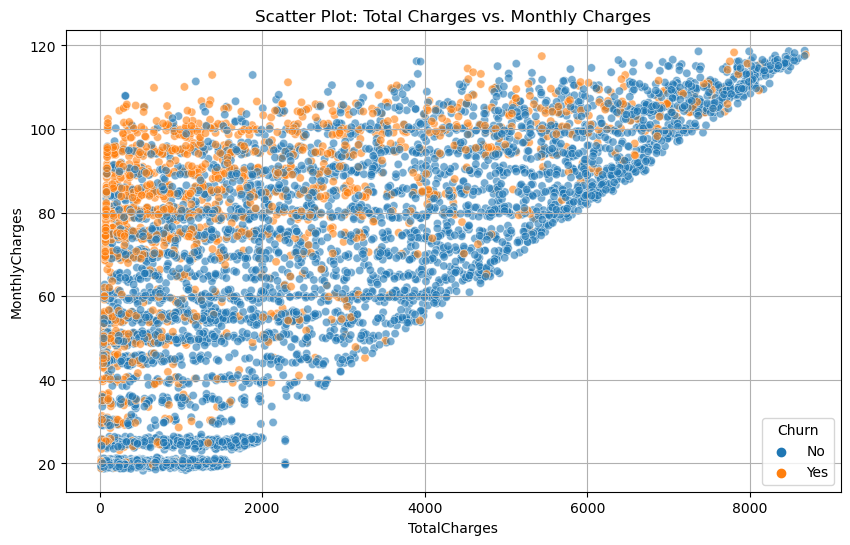

Correlation (Tenure, MonthlyCharges): 0.25
Covariance (Tenure, MonthlyCharges): 183.20
Correlation (TotalCharges, MonthlyCharges): 0.65
Covariance (TotalCharges, MonthlyCharges): 44331.98


In [8]:
# Scatter Plot Function
def plot_scatter(df, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[x_col], y=df[y_col], hue=df['Churn'], alpha=0.6)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.show()

# Scatter plot: Tenure vs. MonthlyCharges
plot_scatter(data, 'tenure', 'MonthlyCharges', 'Scatter Plot: Tenure vs. Monthly Charges')

# Scatter plot: TotalCharges vs. MonthlyCharges
plot_scatter(data, 'TotalCharges', 'MonthlyCharges', 'Scatter Plot: Total Charges vs. Monthly Charges')

# Calculate correlation and covariance
corr_tenure_monthly = data['tenure'].corr(data['MonthlyCharges'])
cov_tenure_monthly = data['tenure'].cov(data['MonthlyCharges'])
corr_total_monthly = data['TotalCharges'].corr(data['MonthlyCharges'])
cov_total_monthly = data['TotalCharges'].cov(data['MonthlyCharges'])

print(f'Correlation (Tenure, MonthlyCharges): {corr_tenure_monthly:.2f}')
print(f'Covariance (Tenure, MonthlyCharges): {cov_tenure_monthly:.2f}')
print(f'Correlation (TotalCharges, MonthlyCharges): {corr_total_monthly:.2f}')
print(f'Covariance (TotalCharges, MonthlyCharges): {cov_total_monthly:.2f}')


# Hypothesis Testing Analysis
To test our hypothesis about the impact of tenure and contract type on churn, we'll use a binomial test to compare churn rates between customers on different contract types.

In [9]:
# Binomial test for churn rate between contract types
contract_counts = data.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
print(contract_counts)

# Perform binomial test for month-to-month vs. two-year contracts
p_value = binom_test(
    [contract_counts.loc['Month-to-month', 'Yes'], contract_counts.loc['Two year', 'Yes']],
    [contract_counts.loc['Month-to-month'].sum(), contract_counts.loc['Two year'].sum()],
    alternative='two-sided'
)

print(f'Binomial Test p-value: {p_value:.4f}')


Churn                 No       Yes
Contract                          
Month-to-month  0.572903  0.427097
One year        0.887305  0.112695
Two year        0.971681  0.028319
Binomial Test p-value: 1.0000


C:\Users\jwsue\AppData\Local\Temp\ipykernel_14628\1003609139.py:6: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = binom_test(


# Regression Analysis
We'll perform a regression analysis to quantify the impact of tenure, monthly charges, and contract type on customer churn probability.

In [10]:
import statsmodels.api as sm

# Encode categorical variables
data['Contract_Encoded'] = data['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
data['Churn_Encoded'] = data['Churn'].map({'No': 0, 'Yes': 1})

# Prepare regression model
X = data[['tenure', 'MonthlyCharges', 'Contract_Encoded']]
y = data['Churn_Encoded']
X = sm.add_constant(X)

# Fit regression model
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          Churn_Encoded   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     677.1
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:08:23   Log-Likelihood:                -3343.0
No. Observations:                7043   AIC:                             6694.
Df Residuals:                    7039   BIC:                             6721.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2622      0.012  